In [1]:
from deap import creator, base, tools, algorithms
import random
import arcade
import numpy as np
import time

In [2]:
# Definindo Constantes
toolbox = base.Toolbox()

SPRITE_SCALING_PLAYER = 0.25
SPRITE_SCALING_OBSTACLE = 0.1
OBSTACLE_COUNT = 30 
PLAYER_COUNT = 1 
VELOCIDADE = 10 # Velocidade para o Player e para os Obstaculos moveis
RAIO = 100 # Raio de visao
sizes = [3*OBSTACLE_COUNT + 2, 10, 5, 1] # Camadas para a Rede Neural


SCREEN_WIDTH = 1400
SCREEN_HEIGHT = 700
SCREEN_TITLE = "Projeto Sistemas Evolutivos"

# Função Sigmoid

In [3]:
# Funcao Sigmoid
import math

def sigmoid(z):
    return 2.0/(1.0 + np.exp(-z)) - 1 

# Definindo Elementos

In [4]:
# Definindo o Obstaculo Movel

class Obstacle(arcade.Sprite):
    def __init__(self, filename, sprite_scaling):
        # Componentes do Jogador
        super().__init__(filename, sprite_scaling)
        self.change_x = random.randrange(-1, 2, 2)*VELOCIDADE
        self.change_y = random.randrange(-1, 2, 2)*VELOCIDADE
        self.center_x = random.randrange(SCREEN_WIDTH)
        self.center_y = random.randrange(SCREEN_HEIGHT)
        # Garantir que nao surjam no raio de visao do individuo
        while(abs(self.center_x - SCREEN_WIDTH/2) ** 2 + abs(self.center_y - SCREEN_HEIGHT/2) ** 2 <= 10000): 
            self.center_x = random.randrange(SCREEN_WIDTH)
            self.center_y = random.randrange(SCREEN_HEIGHT)

    def update(self):
        self.center_x += self.change_x
        self.center_y += self.change_y
        if self.center_x < 0 or self.center_x > SCREEN_WIDTH:
            self.change_x *= -1
        if self.center_y < 0 or self.center_y > SCREEN_HEIGHT:
            self.change_y *= -1

In [5]:
# Definindo o Jogador
class Player(arcade.Sprite):
    def __init__(self, filename, sprite_scaling):
        # Componentes do Jogador
        super().__init__(filename, sprite_scaling)
        self.time = 0
        self.change_x = VELOCIDADE
        self.change_y = VELOCIDADE
        self.center_x = SCREEN_WIDTH/2
        self.center_y = SCREEN_HEIGHT/2
        self.nearObstacles = set()
        self.qtdNearObstacles = 0
        # Pesos da Rede Neural
        self.weights = []

    def update(self):
        # Acrescentando o tempo
        self.time += 1 / 120
        # "Raciocinio"
        a = []
        for obs in self.nearObstacles:
            a.append([(obs.center_x - obs.change_x) - self.center_x, (obs.center_y - obs.change_y) - self.center_y])
            a.append([obs.center_x - self.center_x, obs.center_y - self.center_y])
        ax = []
        ay = []
        cont = 0
        ax.append(self.center_x * (-1))
        ay.append(self.center_y * (-1))
        ax.append(SCREEN_WIDTH - self.center_x)
        ay.append(SCREEN_HEIGHT - self.center_y)
        for i in a:
            ax.append(i[0])
            ay.append(i[1])
            if cont % 2 == 1:
                ax.append(1)
                ay.append(1)
            cont += 1
        for i in range(len(ax), sizes[0], 3):
            ax.append(0)
            ax.append(0)
            ay.append(0)
            ay.append(0)
            ax.append(-1)
            ay.append(-1)
        ax = np.array(ax)
        ay = np.array(ay)
        for w in self.weights:
            ax = sigmoid(np.dot(w, ax))
            ay = sigmoid(np.dot(w, ay))

        # Movimento em X
        if ax[0] < -(1/3) and self.center_x > self.width / 1.5:
            self.center_x -= self.change_x
        elif ax[0] > (1/3) and self.center_x < SCREEN_WIDTH - (self.width / 1.5):
            self.center_x += self.change_x
        # Movimento em Y
        if ay[0] < -(1/3) and self.center_y > self.width / 1.5:
            self.center_y -= self.change_y
        elif ay[0] > (1/3) and self.center_y < SCREEN_HEIGHT - (self.width / 1.5):
            self.center_y += self.change_y

# Função para avaliar o indivíduo

In [6]:
# Função Evaluate para avaliar individuo
def evaluate(pesos):
    time = 0
    distSquare = 0
    distScore = 0
    player_list = arcade.SpriteList()
    obstacle_list = arcade.SpriteList()
    component_list = arcade.SpriteList()

    # Craindo Player com os pesos (individuo)
    individual = Player(":resources:images/animated_characters/female_person/"
                        "femalePerson_idle.png", SPRITE_SCALING_PLAYER)
    matriz1 = []
    matriz2 = []
    matriz3 = []
    for i in range(quantidade):
        if(i < sizes[0]*sizes[1]):
            matriz1.append(pesos[i])
        elif(i < sizes[0]*sizes[1] + sizes[1]*sizes[2]):
            matriz2.append(pesos[i])
        else:
            matriz3.append(pesos[i])
    matriz1 = np.array(matriz1)
    matriz2 = np.array(matriz2)
    matriz3 = np.array(matriz3)
    matriz1 = np.reshape(matriz1, (sizes[1], sizes[0]))
    matriz2 = np.reshape(matriz2, (sizes[2], sizes[1]))
    matriz3 = np.reshape(matriz3, (sizes[3], sizes[2]))
    individual.weights = [matriz1, matriz2, matriz3]

    # Adicionando individuo às listas
    component_list.append(individual)
    player_list.append(individual)

    # Criando Obstaculos moveis
    for i in range(OBSTACLE_COUNT):
        new_obstacle = Obstacle(":resources:images/items/coinGold.png", SPRITE_SCALING_OBSTACLE)
        obstacle_list.append(new_obstacle)
        component_list.append(new_obstacle)

    cabou = 0
    
    # Avaliar individuo
    while cabou == 0:
        posXAnterior = individual.center_x
        posYAnterior = individual.center_y
        # Adiciona obstáculos dentro do raio de visao
        for ind in player_list:
            for obstacle in obstacle_list:
                dist = math.sqrt((ind.center_x - obstacle.center_x) ** 2 +
                                 (ind.center_y - obstacle.center_y) ** 2)
                if dist <= RAIO:
                    ind.nearObstacles.add(obstacle)
                    ind.qtdNearObstacles += 1

        # Retira obstaculos que sairam do raio de visao
        for ind in player_list:
            for obstacle in ind.nearObstacles.copy():
                dist = math.sqrt((ind.center_x - obstacle.center_x) ** 2 +
                                 (ind.center_y - obstacle.center_y) ** 2)
                if dist > RAIO:
                    ind.nearObstacles.remove(obstacle)
                    ind.qtdNearObstacles -= 1

        # Atualizar posições de componentes
        component_list.update()
        distSquare += math.sqrt((individual.center_x - posXAnterior) ** 2 + (individual.center_y - posYAnterior) ** 2)

        # Verificar colisão e eliminar jogador caso tenha colidido
        for ind in player_list:
            if ind.time > 50: # tempo maximo de sobrevivencia
                time += ind.time
                component_list.remove(ind)
                player_list.remove(ind)
                continue
            hit_list = arcade.check_for_collision_with_list(ind, obstacle_list)
            if len(hit_list) != 0:
                time += ind.time
                ind.remove_from_sprite_lists()
        if len(player_list) == 0:
            return time, 

# Definindo a Parte Visual do Ambiente de Simulação

In [7]:
# Ambiente de Simulação (Parte Visual)
class MyGame(arcade.Window):
    """ Classe da janela de display """

    def __init__(self):
        """ Inicializador """
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE)

        # Variaveis para as listas de Sprites
        self.all_sprites_list = None
        self.obstacle_list = None
        self.player_list = None

        self.time = 0 # tempo inicial

        # Nao mostrar o cursos do mouse
        self.set_mouse_visible(False)
            
        arcade.set_background_color(arcade.color.AMAZON)

    def setup(self):
        """ Configurar o jogo e inicializar as variaveis. """

        # Listas de objetos
        self.all_sprites_list = arcade.SpriteList()
        self.player_list = arcade.SpriteList()
        self.obstacle_list = arcade.SpriteList()

        # Tempo
        self.time = 0 # Zerar tempo

        # Criar Player
        # Imagem para personagem de kenney.nl
        player = Player(":resources:images/animated_characters/female_person/"
                        "femalePerson_idle.png", SPRITE_SCALING_PLAYER)
        player.change_x = 2.5
        player.change_y = 2.5 
        bestpesos = top1[0]
        bestmatriz1 = []
        bestmatriz2 = []
        bestmatriz3 = []
        for i in range(quantidade):
            if(i < sizes[0]*sizes[1]):
                bestmatriz1.append(bestpesos[i])
            elif(i < sizes[0]*sizes[1] + sizes[1]*sizes[2]):
                bestmatriz2.append(bestpesos[i])
            else:
                bestmatriz3.append(bestpesos[i])
        bestmatriz1 = np.array(bestmatriz1)
        bestmatriz2 = np.array(bestmatriz2)
        bestmatriz3 = np.array(bestmatriz3)
        bestmatriz1 = np.reshape(bestmatriz1, (sizes[1], sizes[0]))
        bestmatriz2 = np.reshape(bestmatriz2, (sizes[2], sizes[1]))
        bestmatriz3 = np.reshape(bestmatriz3, (sizes[3], sizes[2]))
        player.weights = [bestmatriz1, bestmatriz2, bestmatriz3]



        # Add player to lists
        self.all_sprites_list.append(player)
        self.player_list.append(player)

        # Create the obstacles
        for i in range(OBSTACLE_COUNT):

            # creating obstacle
            obstacle = Obstacle(":resources:images/items/coinGold.png", SPRITE_SCALING_OBSTACLE)

            # Position the obstacle
            obstacle.center_x = random.randrange(SCREEN_WIDTH)
            obstacle.center_y = random.randrange(SCREEN_HEIGHT)
            obstacle.change_x = random.randrange(-1, 2, 2)*2.5
            obstacle.change_y = random.randrange(-1, 2, 2)*2.5

            # Add the obstacle to the lists
            self.all_sprites_list.append(obstacle)
            self.obstacle_list.append(obstacle)

    def on_draw(self):
        """ Draw everything """
        self.clear()
        output = f"Time: {round(self.time, 2)}"
        arcade.draw_text(output, 15, 20, arcade.color.WHITE, 14)
        self.all_sprites_list.draw()

        # Put the text on the screen.
        output = f"Time: {round(self.time, 2)}"
        survivors = f"Sobreviventes: {len(self.player_list)}"
        arcade.draw_text(output, 15, 20, arcade.color.WHITE, 14)
        arcade.draw_text(survivors, 150, 20, arcade.color.WHITE, 14)

    def on_update(self, delta_time):
        """ Movement and game logic """
        self.time += 1 / 120
        # Call update on all sprites
        self.all_sprites_list.update()

        # Adicionar obstáculos próximos
        for player in self.player_list:
            for obstacle in self.obstacle_list:
                dist = math.sqrt((player.center_x - obstacle.center_x) ** 2 +
                                 (player.center_y - obstacle.center_y) ** 2)
                if dist <= RAIO:
                    player.nearObstacles.add(obstacle)
                    player.qtdNearObstacles += 1

        # Retira obstaculos que sairam do raio
        for player in self.player_list:
            for obstacle in player.nearObstacles.copy():
                dist = math.sqrt((player.center_x - obstacle.center_x) ** 2 +
                                 (player.center_y - obstacle.center_y) ** 2)
                if dist > RAIO:
                    player.nearObstacles.remove(obstacle)
                    player.qtdNearObstacles -= 1
        # Verificar colisão, imprimir tempo e eliminar jogador
        for player in self.player_list:
            hit_list = arcade.check_for_collision_with_list(player, self.obstacle_list)
            if len(hit_list) != 0:
                # player.remove_from_sprite_lists(self.player_list)
                player.remove_from_sprite_lists()
        if len(self.player_list) == 0:
            arcade.close_window()

In [8]:
# Iniciar o ambiente de simulação (parte visual)
def main():
    window = MyGame()
    window.setup()
    arcade.run()

# Parte Evolutiva

In [9]:
# Numero de elementos na matriz de pesos
quantidade = sizes[0]*sizes[1] + sizes[1]*sizes[2] + sizes[2]*sizes[3]

# Função para gerar pesos aleatórios
def gerapesos():
    return [np.random.uniform(0, 1, (y, x)) for x, y in zip(sizes[:-1], sizes[1:])]

In [10]:
# Definicoes da Biblioteca Deap
creator.create("FitnessMax", base.Fitness, weights=(1.0, ))

creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("weights", np.random.uniform, 0, 1)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.weights, n=quantidade)

toolbox.register("evaluate", evaluate)

toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=100)

toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("select", tools.selTournament, tournsize=3)

# Avaliando o Individuo Variando INDPB (Probabilidade Indivudal de Mutação)

In [11]:
NGEN = 50 # Numero de geracoes
INDPB = np.arange(0, 1.05, 0.05) # Probabilidade do individuo sofrer mutacao
CXPB = 0.5 # Probabilidade de crossover
MUTPB = 0.5 # Probabilidade de mutacao
tempos = [] # Lista de melhor tempo (score) da última geração (Grafico 1)
tempoTotal = [] # lista com somatório dos tempos (score) da ultima geração (Grafico 2)
temposMelhorInd = [] # lista da media de tempo de sobrevivencia do melhor invididuo da ultima geracao (Grafico 3)
population = toolbox.population() # Populacao inicial

for PB in INDPB:
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=PB)
    atual = 0 # somatoria de tempos do melhor individuo
    for gen in range(NGEN):
        total = 0
        offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB) # Produz nova geracao
        fits = toolbox.map(toolbox.evaluate, offspring) # Avalia individuos da geracao atual
        print(f"Geração {gen}:")
        maximo = 0
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
            total += ind.fitness.values[0] 
            if(ind.fitness.values[0] > maximo):
                maximo = ind.fitness.values[0]
            print("PB: ", PB, "G: ", gen," tempo: ", round(ind.fitness.values[0], 2))
        if(gen+1 == NGEN):
            tempos.append(maximo)
            tempoTotal.append(total)
        population = toolbox.select(offspring, k=len(population))
        top1 = tools.selBest(population, k=1) # melhor individuo
        # if((gen+1) % 20 == 0): # Display da simulacao visual com top1 a cada 20 geracoes
            # main()
    for i in range(10):
        atual += evaluate(np.reshape(top1, (-1)))[0]
    temposMelhorInd.append(atual/10) # adicionar media de tempo para o valor de CX atual.

Geração 0:
PB:  0.0 G:  0  tempo:  0.04
PB:  0.0 G:  0  tempo:  0.63
PB:  0.0 G:  0  tempo:  0.05
PB:  0.0 G:  0  tempo:  0.17
PB:  0.0 G:  0  tempo:  0.36
PB:  0.0 G:  0  tempo:  0.33
PB:  0.0 G:  0  tempo:  0.76
PB:  0.0 G:  0  tempo:  0.37
PB:  0.0 G:  0  tempo:  0.58
PB:  0.0 G:  0  tempo:  0.39
PB:  0.0 G:  0  tempo:  0.77
PB:  0.0 G:  0  tempo:  0.04
PB:  0.0 G:  0  tempo:  0.18
PB:  0.0 G:  0  tempo:  1.22


/tmp/ipykernel_24010/979507128.py:5: RuntimeWarning: overflow encountered in exp
  return 2.0/(1.0 + np.exp(-z)) - 1


PB:  0.0 G:  0  tempo:  1.65
PB:  0.0 G:  0  tempo:  0.32
PB:  0.0 G:  0  tempo:  0.6
PB:  0.0 G:  0  tempo:  0.51
PB:  0.0 G:  0  tempo:  0.25
PB:  0.0 G:  0  tempo:  0.75
PB:  0.0 G:  0  tempo:  0.07
PB:  0.0 G:  0  tempo:  0.25
PB:  0.0 G:  0  tempo:  1.03
PB:  0.0 G:  0  tempo:  0.36
PB:  0.0 G:  0  tempo:  6.14
PB:  0.0 G:  0  tempo:  0.17
PB:  0.0 G:  0  tempo:  0.26
PB:  0.0 G:  0  tempo:  0.15
PB:  0.0 G:  0  tempo:  0.39
PB:  0.0 G:  0  tempo:  0.6
PB:  0.0 G:  0  tempo:  0.56
PB:  0.0 G:  0  tempo:  0.76
PB:  0.0 G:  0  tempo:  1.05
PB:  0.0 G:  0  tempo:  0.08
PB:  0.0 G:  0  tempo:  0.51
PB:  0.0 G:  0  tempo:  1.09
PB:  0.0 G:  0  tempo:  0.61
PB:  0.0 G:  0  tempo:  0.22
PB:  0.0 G:  0  tempo:  0.2
PB:  0.0 G:  0  tempo:  0.31
PB:  0.0 G:  0  tempo:  1.02
PB:  0.0 G:  0  tempo:  0.17
PB:  0.0 G:  0  tempo:  1.02
PB:  0.0 G:  0  tempo:  1.34
PB:  0.0 G:  0  tempo:  0.21
PB:  0.0 G:  0  tempo:  0.43
PB:  0.0 G:  0  tempo:  0.58
PB:  0.0 G:  0  tempo:  0.29
PB:  0.0 G:  0  t

# Gráfico 1: Melhor Tempo (score) X INDPB (Probabilidade Indivudal de Mutação)

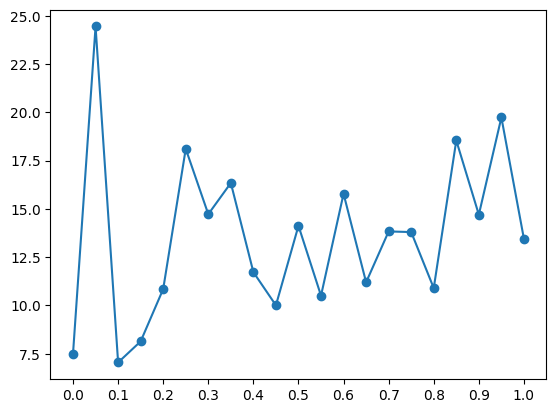

In [12]:
# Leva em consideração o tempo de sobrevivência do melhor individuo da ultima geração

import matplotlib.pyplot as plt

plt.scatter(INDPB, tempos)
plt.plot(INDPB, tempos)
plt.xticks(np.arange(0, 1.05, 0.1)) 
plt.show()

# Gráfico 2: Tempo Total X INDPB (Probabilidade Indivudal de Mutação)

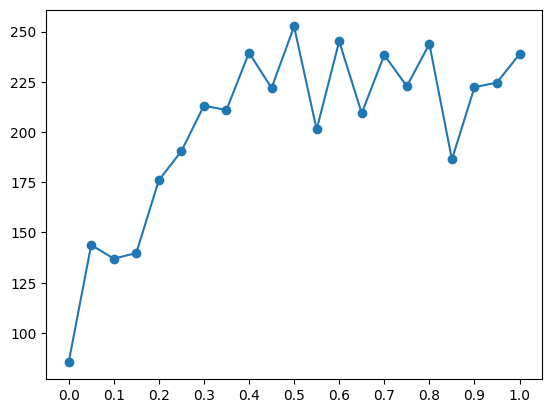

In [13]:
# Leva em consideração o tempo de sobrevivência do melhor individuo da ultima geração

plt.scatter(INDPB, tempoTotal)
plt.plot(INDPB, tempoTotal)
plt.xticks(np.arange(0, 1.05, 0.1)) 
plt.show()

# Gráfico 3: Média de Tempo X INDPB (Probabilidade Indivudal de Mutação)

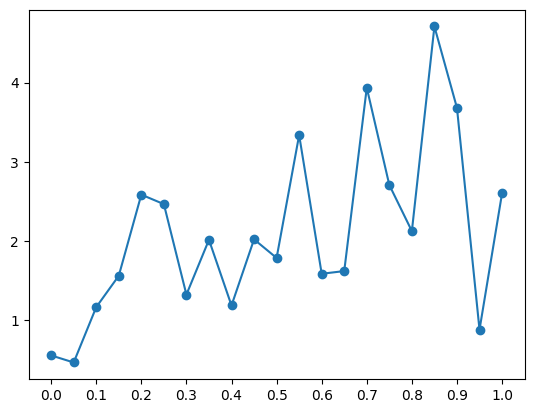

In [14]:
plt.scatter(INDPB, temposMelhorInd)
plt.plot(INDPB, temposMelhorInd)
plt.xticks(np.arange(0, 1.05, 0.1)) 
plt.show()

## Define-se o melhor valor do parâmetro analisado ponderando os valores encontrados nos gráficos seguindo a Ordem de Importância 3 -> 2 -> 1

In [16]:
main()

/tmp/ipykernel_24010/979507128.py:5: RuntimeWarning: overflow encountered in exp
  return 2.0/(1.0 + np.exp(-z)) - 1


# Resultado: INDPB = 0.85